# Road Extraction From Satellite Images
author: Jakub Dulas

dataset: https://www.kaggle.com/datasets/balraj98/deepglobe-road-extraction-dataset

## Importing libraries

In [1]:
import tensorflow as tf
import tensorflow.keras.backend as K
import os
import numpy as np
from sklearn.utils import class_weight
import pandas as pd
import cv2

## Data Preprocessing

In [2]:
PATHS = {
    'train': 'data/train',
    'val': 'data/valid',
    'test': 'data/test',
}

IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS = 256, 256, 1
NUM_EPOCHS = 40
BATCH_SIZE = 64

### Loading images

In [3]:

csv_ds = pd.read_csv('data/metadata.csv')
images = []
masks = []

for idx, row in csv_ds.iterrows():
    _, set, path_img, path_mask = row
    if set == 'train':
        path_img = path_img.strip()
        path_img = os.path.join('data', path_img)
        if not os.path.exists(path_img): continue

        path_mask = path_mask.strip()
        path_mask = os.path.join('data', path_mask)
        if not os.path.exists(path_mask): continue
        
        img = cv2.imread(path_img)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = cv2.resize(img, (IMG_HEIGHT, IMG_WIDTH))
        img = img.astype('float16')
        img = img.reshape((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
        img /= 255.

        mask = cv2.imread(path_mask)
        mask = cv2.resize(mask, (IMG_HEIGHT, IMG_WIDTH))
        mask = mask[:, :, :1]
        mask = mask.astype('float16')
        mask /= 255.

        images.append(img)
        masks.append(mask)

In [4]:
images = np.array(images)
masks = np.array(masks)

In [5]:
images.shape, masks.shape

((6226, 256, 256, 1), (6226, 256, 256, 1))

### Saving images as numpy arrays into file 

In [73]:
filename = 'data.npz'
np.savez_compressed(filename, masks, images)

### Loading images as numpy arrays from file 

In [3]:
data = np.load('data.npz')
images = data['arr_1']
masks = data['arr_0']

In [4]:
masks[masks>0.5] = 1
masks[masks<=0.5] = 0

### Spliting dataset into subsets

In [5]:
n_images = len(images)
val_split = int(0.8*n_images)
test_split = int(0.9*n_images)

train_images = images[:val_split]
train_masks = masks[:val_split]

val_images = images[val_split:test_split]
val_masks = masks[val_split:test_split]

test_images = images[test_split:]
test_masks = masks[test_split:]

### Image Generator
I use it load images to model progressively.

In [7]:
generator = tf.keras.preprocessing.image.ImageDataGenerator()
train_gen = generator.flow(train_images, train_masks)
val_gen = generator.flow(val_images, val_masks)

In [8]:
class_weights = class_weight.compute_class_weight('balanced',
                                                classes=np.unique(train_masks),
                                                y=np.ravel(train_masks, order='C'))
class_weights

array([ 0.52369539, 11.05057448])

## Creating the Model



### Own Loss Function

In [6]:

def dice_coef(y_true, y_pred, smooth=1e-7):        
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    dice = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return dice

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)


In [48]:
def conv_block(input, filters):
    x = tf.keras.layers.Conv2D(filters, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(input)
    # x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.1)(x)
    x = tf.keras.layers.Conv2D(filters, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(x)
    # x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.1)(x)
    return x

def encoder_block(input, filters):
    c = conv_block(input, filters)
    x = tf.keras.layers.MaxPool2D((2, 2))(c)
    return c, x

def decoder_block(input, input2, filters):
    x = conv_block(input, filters)
    x = tf.keras.layers.Conv2DTranspose(filters, (2, 2), 2, padding="same")(x)
    x = tf.keras.layers.concatenate([x, input2])
    return x

def build_unet():
    input = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    c1, x = encoder_block(input, 8*2)
    c2, x = encoder_block(x, 16*2)
    c3, x = encoder_block(x, 32*2)
    c4, x = encoder_block(x, 64*2)
    x = decoder_block(x, c4, 128*2)
    x = decoder_block(x, c3, 64*2)
    x = decoder_block(x, c2, 32*2)
    x = decoder_block(x, c1, 16*2)
    x = conv_block(x, 8*2)
    output = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(x)
    model = tf.keras.Model(inputs=[input], outputs=[output])
    return model

In [49]:
model = build_unet()

In [50]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_57 (Conv2D)             (None, 256, 256, 16  160         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 dropout_45 (Dropout)           (None, 256, 256, 16  0           ['conv2d_57[0][0]']              
                                )                                                           

In [21]:
# tf.keras.utils.plot_model(model, to_file="UnetArchitecture2.png", show_shapes=True, show_layer_names=True)

In [51]:
model.compile('adam', loss=[dice_coef_loss], metrics=['binary_accuracy', dice_coef])

In [25]:
checkpointer = tf.keras.callbacks.ModelCheckpoint('checkpoints/model.h5', verbose=1, save_best_only=True)
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
    tf.keras.callbacks.TensorBoard(log_dir='logs'),
    checkpointer
]

In [ ]:
hist = model.fit_generator(train_gen, validation_data=val_gen, epochs=100)

In [52]:
model.load_weights('model_16_1.h5')

### Testing

In [53]:
predicted_masks = model.predict(test_images)

2023-04-14 19:12:20.961439: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


20/20 [==============================] - 6s 306ms/step


In [54]:
idx = 6

dice_coef(tf.cast(test_masks[idx], 'float32'), tf.cast(predicted_masks[idx], 'float32'))

<tf.Tensor: shape=(), dtype=float32, numpy=0.8225161>

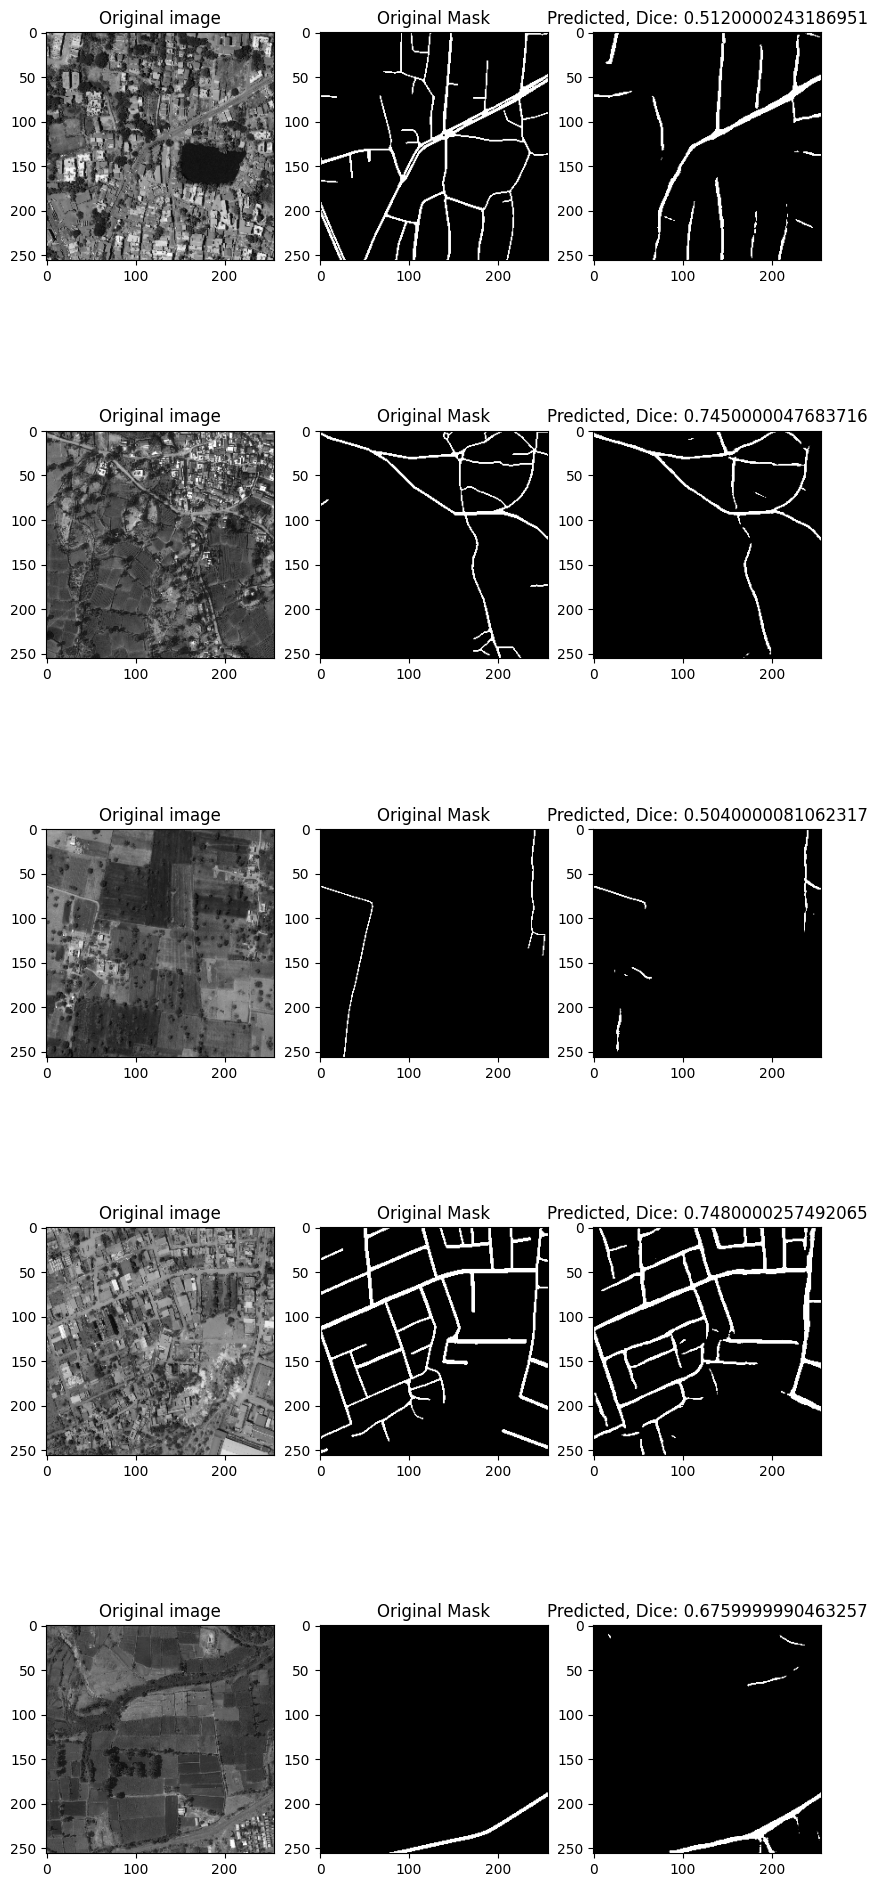

In [55]:
import matplotlib.pyplot as plt

f = plt.figure(figsize=(10, 25))
idx = 0
num_images = 5
for real, mask, pred in zip(test_images[:num_images], test_masks[:num_images], predicted_masks[:num_images]):
    idx += 1
    f.add_subplot(num_images ,3, idx)
    plt.imshow(np.rot90(real,3), 'gray')
    plt.title(f"Original image")
    idx += 1
    f.add_subplot(num_images ,3, idx)
    plt.imshow(np.rot90(mask,3), 'gray')
    plt.title(f"Original Mask")
    idx += 1
    f.add_subplot(num_images ,3, idx)
    plt.imshow(np.rot90(pred,3), 'gray')
    dice = np.round(dice_coef(tf.cast(mask, 'float32'), tf.cast(pred, 'float32')), 3)
    # dice = 3
    plt.title(f"Predicted, Dice: {dice}")
  
    
plt.show(block=True)

In [56]:
dice_coef(tf.cast(test_masks, 'float32'), tf.cast(predicted_masks, 'float32'))

<tf.Tensor: shape=(), dtype=float32, numpy=0.6907128>